In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(num_samples=1000):
    x = np.linspace(0, 10, num_samples)
    y = x * np.sin(2 * x) #+ 0.1 * np.random.randn(num_samples)
    
    # Feature Engineering
    x_sin = np.sin(2 * x)
    x_cos = np.cos(2 * x)
    x_features = np.column_stack((x, x_sin, x_cos, x**2, x**3))
    
    return x_features.astype(np.float32), y.astype(np.float32)

In [3]:
class LSTM1DNet(nn.Module):
    def __init__(self, input_size=5):  # Assuming 5 features from the feature engineering
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        # Reshape x for LSTM input (batch_size, sequence_length, input_size)
        x = x.view(-1, 1, x.size(1))
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])

In [4]:
# Or for a deeper feedforward network:
class Deep1DNet(nn.Module):
    def __init__(self, input_size=5):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 32)
        # self.bn1 = nn.BatchNorm1d(32)
        # self.fc2 = nn.Linear(32, 512)
        # self.bn2 = nn.BatchNorm1d(512)
        # self.fc3 = nn.Linear(512, 256)
        # self.bn3 = nn.BatchNorm1d(256)
        # self.fc4 = nn.Linear(256, 128)
        # self.bn4 = nn.BatchNorm1d(128)
        # self.fc5 = nn.Linear(128, 32)
        # self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.bn2(self.fc2(x)))
        # x = self.dropout(x)
        # x = F.relu(self.bn3(self.fc3(x)))
        # x = F.relu(self.bn4(self.fc4(x)))
        # x = F.relu(self.bn5(self.fc5(x)))
        return self.fc6(x)

In [5]:
def custom_periodic_loss(preds, targets):
    mse_loss = nn.MSELoss()(preds, targets)
    # Add a term to penalize deviation from periodicity
    periodic_penalty = torch.mean(torch.abs(torch.sin(2 * preds) - torch.sin(2 * targets)))
    return mse_loss # 0.1 * periodic_penalty

x=8.01, predicted=2.01, actual=-2.43
x=8.02, predicted=2.02, actual=-2.58
x=8.03, predicted=2.03, actual=-2.74
x=8.04, predicted=2.04, actual=-2.89
x=8.05, predicted=2.04, actual=-3.05
Epoch 100: Train Loss = 0.172127, Val Loss = 1.255387, MAE = 6.754800, LR = 0.000090
Epoch 200: Train Loss = 0.166811, Val Loss = 1.260048, MAE = 6.770444, LR = 0.000001
Epoch 300: Train Loss = 0.166716, Val Loss = 1.260144, MAE = 6.770778, LR = 0.000000
x=8.01, predicted=2.49, actual=-2.43
x=8.02, predicted=2.48, actual=-2.58
x=8.03, predicted=2.46, actual=-2.74
x=8.04, predicted=2.45, actual=-2.89
x=8.05, predicted=2.44, actual=-3.05


/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_8659/4037972528.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  first_plot.show()
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_8659/4037972528.py:120: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  last_plot.show()


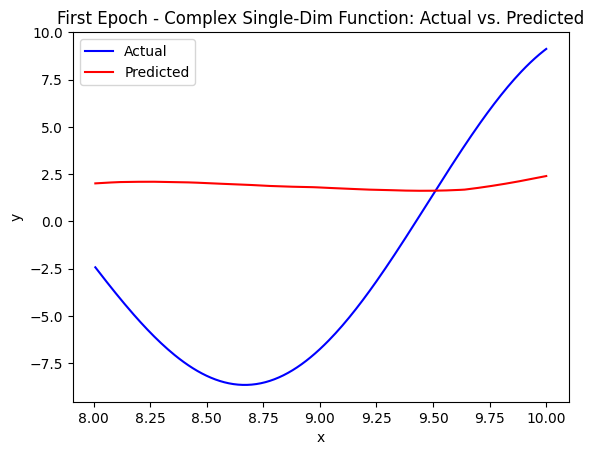

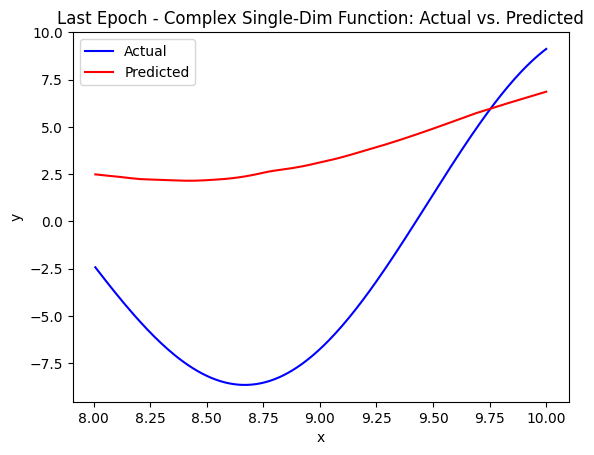

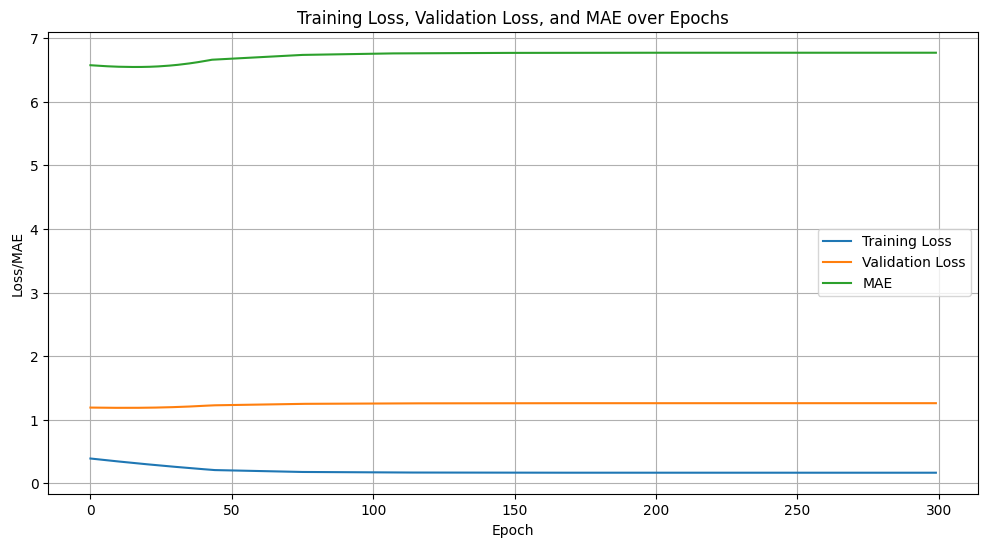

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    # Generate data
    x, y = generate_data(num_samples=1000)
    X_tensor = torch.from_numpy(x).float()  # Convert to float tensor
    Y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # Ensure y is a 2D tensor

    # Create model
    model = Deep1DNet(input_size=X_tensor.shape[1])
    criterion =  nn.HuberLoss() #nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.3)

    # Normalize data
    x_mean, x_std = X_tensor.mean(dim=0), X_tensor.std(dim=0)
    y_mean, y_std = y.mean(), y.std()
    X_normalized = (X_tensor - x_mean) / x_std
    Y_normalized = (Y_tensor - y_mean) / y_std

    # Split into train and test
    train_size = int(0.8 * len(X_normalized))
    X_train, X_test = X_normalized[:train_size], X_normalized[train_size:]
    Y_train, Y_test = Y_normalized[:train_size], Y_normalized[train_size:]

    patience = 100  # number of epochs to wait for improvement
    best_val_loss = float('inf')
    
    counter = 0


    # Variables to store plots
    first_plot = None
    last_plot = None
    first_epoch_loss = None
    last_epoch_loss = None

    # Lists to store MAE, train_loss, and val_loss for each epoch
    mae_values = []
    train_losses = []
    val_losses = []

    # Train
    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, Y_train)
        loss.backward()
        optimizer.step()

        # Evaluate and visualize
        model.eval()
        with torch.no_grad():
            predictions_normalized = model(X_test).numpy().flatten()
            predictions = (predictions_normalized * y_std.item()) + y_mean.item()
            y_test_np = (Y_test.numpy().flatten() * y_std.item()) + y_mean.item()

            val_loss_tensor = criterion(model(X_test), Y_test)
            val_loss = val_loss_tensor.item()

            # Calculate MAE for this epoch
            mae = np.mean(np.abs(predictions - y_test_np))
            mae_values.append(mae)
            train_losses.append(loss.item())
            val_losses.append(val_loss)


        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        scheduler.step(val_loss)

        if epoch == 0:  # First epoch
            first_epoch_loss = (loss.item(), val_loss)
    
        elif epoch == 299:  # Last epoch (since 0-indexed)
            last_epoch_loss = (loss.item(), val_loss)


        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {loss.item():.6f}, Val Loss = {val_loss:.6f}, MAE = {mae:.6f}, LR = {optimizer.param_groups[0]['lr']:.6f}")
        # if counter >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
            # break  # This should be indented to be inside the for loop

        # Post-training evaluation and visualization
        if epoch == 0 or epoch == 299:
                model.eval()
                with torch.no_grad():
                    predictions_normalized = model(X_test).numpy().flatten()
                    predictions = (predictions_normalized * y_std.item()) + y_mean.item()
                    x_test_np = (X_test.numpy()[:, 0] * x_std[0].item()) + x_mean[0].item()
                    y_test_np = (Y_test.numpy().flatten() * y_std.item()) + y_mean.item()

                for i in range(5):
                    print(f"x={x_test_np[i]:.2f}, predicted={predictions[i]:.2f}, actual={y_test_np[i]:.2f}")

                fig, ax = plt.subplots()
                ax.plot(x_test_np, y_test_np, label='Actual', color='blue')
                ax.plot(x_test_np, predictions, label='Predicted', color='red')
                ax.legend()
                ax.set_xlabel('x')
                ax.set_ylabel('y')
                ax.set_title(f'{"First" if epoch == 0 else "Last"} Epoch - Complex Single-Dim Function: Actual vs. Predicted')
               
                if epoch == 0:
                    first_plot = fig
                else:
                    last_plot = fig
            
        # Show plots after training
        if first_plot and last_plot:
            first_plot.show()
            last_plot.show()
        # else:
        #     print("Plot data not captured as expected.")
# Save plots after the loop
    if first_plot:
        first_plot.savefig('first_epoch_plot.png')
    if last_plot:
        last_plot.savefig('last_epoch_plot.png')
    else:
        print("Last plot was not created; check if the loop completed all epochs.")

    # Plotting the losses and MAE
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.plot(mae_values, label='MAE')
    plt.xlabel('Epoch')
    
    plt.ylabel('Loss/MAE')
    plt.title('Training Loss, Validation Loss, and MAE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_mae_plot.png')  # Save the plot to a file
    plt.show()

In [7]:
x_test_np

array([ 8.008008 ,  8.018018 ,  8.0280285,  8.038038 ,  8.048048 ,
        8.058058 ,  8.0680685,  8.078078 ,  8.088088 ,  8.098098 ,
        8.1081085,  8.118118 ,  8.128128 ,  8.138138 ,  8.148149 ,
        8.158158 ,  8.168168 ,  8.178178 ,  8.188189 ,  8.198198 ,
        8.208208 ,  8.218218 ,  8.228229 ,  8.238238 ,  8.248248 ,
        8.258258 ,  8.268269 ,  8.278278 ,  8.288288 ,  8.298298 ,
        8.308309 ,  8.318318 ,  8.328328 ,  8.338338 ,  8.348349 ,
        8.358358 ,  8.368368 ,  8.378378 ,  8.388389 ,  8.398398 ,
        8.408408 ,  8.418419 ,  8.428429 ,  8.438438 ,  8.448448 ,
        8.458459 ,  8.468469 ,  8.478478 ,  8.488488 ,  8.498499 ,
        8.508509 ,  8.518518 ,  8.528528 ,  8.538539 ,  8.548549 ,
        8.558558 ,  8.568568 ,  8.578579 ,  8.588589 ,  8.5985985,
        8.608608 ,  8.618619 ,  8.628629 ,  8.6386385,  8.648648 ,
        8.658659 ,  8.668669 ,  8.6786785,  8.688688 ,  8.698699 ,
        8.708709 ,  8.718719 ,  8.728728 ,  8.738739 ,  8.7487

In [8]:
print(X_tensor.shape[1])

5


In [9]:
# plt.xstick(np.arange(0, 10, 0.1))